In [451]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.special import expit
%matplotlib inline

In [452]:
# Visualization 

from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges


def draw_graph(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # Left to Right

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # for any value in graph, create a rectangular ('record') node for it.
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.gradient), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1,n2 in edges:
        # connect n1 to op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)


    return dot

In [453]:

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.gradient = 1 # intially no effect
        self._backward = lambda:None
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        result = self.data + other.data
        out = Value(result, (self, other), '+')
        def _backward():
            self.gradient = out.gradient * 1
            other.gradient = out.gradient * 1
        out._backward = _backward
        return out
        
    def __mul__(self, other):
        result = self.data * other.data
        out = Value(result, (self, other), '*')
        def _backward():
            self.gradient = out.gradient * other.data
            other.gradient = out.gradient * self.data
        out._backward = _backward
        return out

    def sigmoid(self):
        x = self.data
        res = 1 / (1 + math.exp(-x))
        out = Value(res, (self,), 'sigmoid')
        def _backward():
            self.gradient = (res * (1 - res)) * out.gradient
        out._backward = _backward
        return out

    def ReLU(self):
        x = self.data
        res = abs(x * (x > 0))
        out = Value(res, (self,), 'ReLU')
        def _backward():
            if x > 0:
                self.gradient = 1 * out.gradient
            else:
                self.gradient = 0 * out.gradient
        out._backward = _backward
        return out
        

In [454]:
a = Value(5.1);a.label = 'a'
b = Value(4.1);b.label = 'b'
f = Value(2.4);f.label = 'f'

e = a + b; e.label = 'e'
d = e * f;d.label='d'

# g = d.sigmoid(); g.label = 'g'
g = d.ReLU(); g.label = 'g'


print(e.gradient)
print(a.gradient)
print(b.gradient)


1
1
1


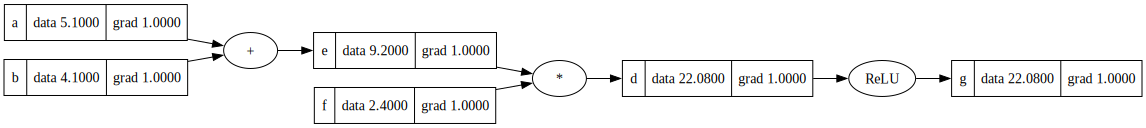

In [455]:
# Forward pass
draw_graph(g)

In [456]:
def updateGradients(node: Value):
    if len(node._prev) > 0:
        node._backward()
        for prev_node in node._prev:
            updateGradients(prev_node)

In [457]:
updateGradients(g)

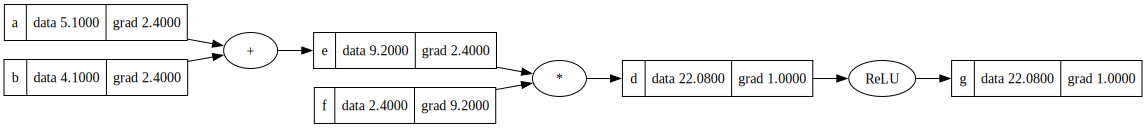

In [458]:
# backward pass - gradient calculation
draw_graph(g)

In [459]:
# Node
# node._backward just accessing the function
# node._backward() executing the function

In [460]:
print(d)

Value(data=22.08)


In [461]:
# Increasing d - Go in the direction of gradient

a.data += 0.01 * a.gradient
b.data += 0.01 * b.gradient
f.data += 0.01 * f.gradient

e = a + b; e.label = 'e'
d = e * f;d.label='d'
g = d.ReLU(); g.label = 'g'

In [462]:
print(g)

Value(data=23.046015999999998)


In [463]:
print(a.gradient)

2.4


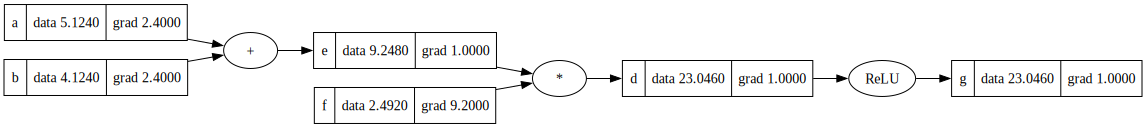

In [464]:
draw_graph(g)

In [465]:
# Decreasing d - Go in the opposite direction of gradient
# Update leaf nodes.
a.data -= 0.01 * a.gradient
b.data -= 0.01 * b.gradient
f.data -= 0.01 * f.gradient

e = a + b; e.label = 'e'
d = e * f;d.label='d'
g = d.ReLU(); g.label = 'g'

In [466]:
print(g)

Value(data=22.08)


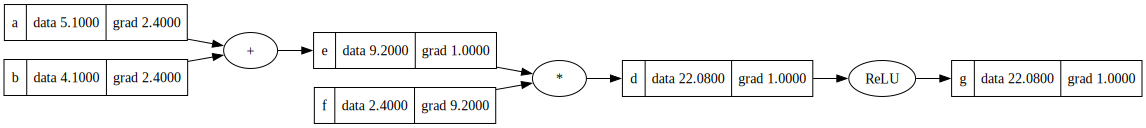

In [467]:
draw_graph(g)

In [468]:
x = 18.00
res = 1 / (1 + math.exp(-x))
round(res)

1

In [469]:
x = -0.1
abs(x * (x > 0))

0.0

In [473]:
# If we consider g as loss function - To decrease loss function go in opposite direction of gradients

k = 0.001
max_iterations = 20
tolerance = 1e-6
g_prev = float('inf')  # Previous loss value

for iteration in range(max_iterations):
    # Compute gradients TODO
    # In a typical gradient descent implementation, 
    # gradients are recalculated each time we update the parameters.
    
    # Forward prop
    a.data -= k * a.gradient
    b.data -= k * b.gradient
    f.data -= k * f.gradient

    # Recompute loss
    e = a + b; e.label = 'e'
    d = e * f;d.label='d'

    # g = d.sigmoid(); g.label = 'g'
    g = d.ReLU(); g.label = 'g'

    # Gradients
    updateGradients(a)
    updateGradients(b)
    updateGradients(f)
    
    # Print loss value
    print(f"Iteration {iteration + 1}: Value of g - {g.data}")

    # Check for convergence
    if abs(g_prev - g.data) < tolerance:
        print("Convergence reached.")
        break
    g_prev = g.data

print("Optimization completed.")

Iteration 1: Value of g - 20.080114560000045
Iteration 2: Value of g - 19.98585344000005
Iteration 3: Value of g - 19.89168064000005
Iteration 4: Value of g - 19.79759616000005
Iteration 5: Value of g - 19.703600000000055
Iteration 6: Value of g - 19.60969216000006
Iteration 7: Value of g - 19.515872640000058
Iteration 8: Value of g - 19.42214144000006
Iteration 9: Value of g - 19.328498560000064
Iteration 10: Value of g - 19.234944000000066
Iteration 11: Value of g - 19.14147776000007
Iteration 12: Value of g - 19.04809984000007
Iteration 13: Value of g - 18.95481024000007
Iteration 14: Value of g - 18.861608960000073
Iteration 15: Value of g - 18.768496000000077
Iteration 16: Value of g - 18.675471360000078
Iteration 17: Value of g - 18.58253504000008
Iteration 18: Value of g - 18.48968704000008
Iteration 19: Value of g - 18.396927360000085
Iteration 20: Value of g - 18.304256000000084
Optimization completed.


In [474]:
print(a.gradient)

2.4


In [475]:
# Check how 'g' is decreasing.